In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [ ]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


---

### Задание1

In [4]:
# Define function and derivatives
def f(x): 
    if isinstance(x, int) or isinstance(x, float):
        x = [x]
    return np.array([-2*np.log(x_) - 3*x_ - np.log(1 - x_**2) for x_ in x])

def d1_f(x):
    if isinstance(x, int) or isinstance(x, float):
        x = [x]
    return np.array([-2/x_ -3 + (2*x_)/(1 - x_**2) for x_ in x])

def d2_f(x):
    if isinstance(x, int) or isinstance(x, float):
        x = [x]
    return np.array([2/x_**2 + (2 + 2*x_**2)/(1 - x_**2)**2 for x_ in x])

In [5]:
alpha = 0.03
x_old = 0.2
x_new = x_old
history_x_list = [x_old]
for i in range(5):
    print(f'{i+1} step:')
    x_new = x_old - alpha*d1_f(x_old)[0]
    x_old = x_new
    print('x:', x_new, end='\n'*2)
    history_x_list.append(x_old)

1 step:
x: 0.5775

2 step:
x: 0.7194076193829333

3 step:
x: 0.8033407819430808

4 step:
x: 0.8321165263779403

5 step:
x: 0.8319009432063161



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


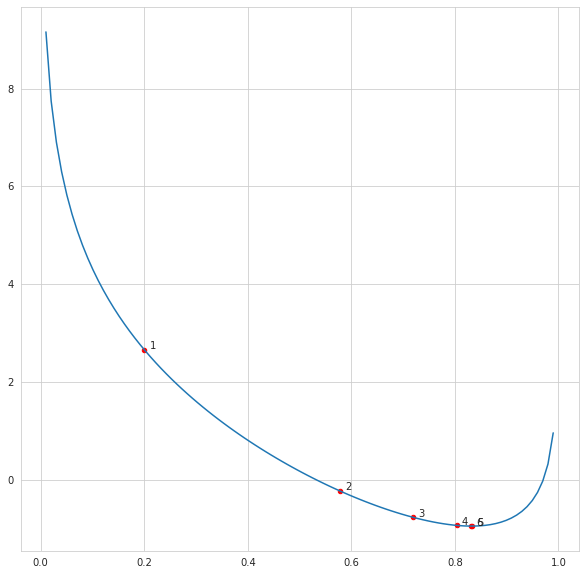

In [7]:
x_dom = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 10))
plt.plot(x_dom, f(x_dom));
for i in range(len(history_x_list)):
    plt.scatter(history_x_list[i], f(history_x_list[i]), color='red', s=20);
    plt.text(history_x_list[i]+0.01, f(history_x_list[i])+0.01, i+1, size=10);

### Задание 7

In [8]:
from itertools import product
import numpy as np

def generate_points(n: int=1000, p1: float=0.5, p2: float=0.5):
    theta1, theta2 = 0.5, 0.75
    X = []
    for i in range(n):
        x1 = np.random.choice([0, 1], p=[1 - p1, p1])
        x2 = np.random.choice([0, 1], p=[1 - p2, p2])
        x3 = np.random.choice(
            [0, 1], 
            # conditional probability p(x3 | x1, x2)
            p=[1 - np.exp(-theta1**2 - theta2**2*(x1 - x2)**2), np.exp(-theta1**2 - theta2**2*(x1 - x2)**2)]
        )
        X.append([x1, x2, x3])
    return np.array(X)

X = generate_points()

def compute_statistics(X: np.ndarray) -> dict:
    
    """
    Computes n_000, n_001, ..., n_111
    """
    
    statistics_dict = {}
    for i, j, k in product([0, 1], [0, 1], [0, 1]): # 2^3 cases
        # make n_ijk
        statistics_dict[f"n_{i}{j}{k}"] = X[
            (X[:, 0] == i) & (X[:, 1] == j) & (X[:, 2] == k)
        ].shape[0]
    return statistics_dict

statistics_dict = compute_statistics(X)


def log_likelihood(theta1: float, theta2: float, p1: float, p2: float, X: np.ndarray=X) -> float:
    
    """
    Computes log likelihood
    """
    
    stats = compute_statistics(X)
    
    res = (stats['n_000'] + stats['n_110']) * np.log(1 - np.exp(-theta1**2)) \
        - (stats['n_001'] + stats['n_111']) * theta1**2 \
        + (stats['n_100'] + stats['n_010']) * np.log(1 - np.exp(-theta1**2 - theta2**2)) \
        - (stats['n_101'] + stats['n_011']) * (theta1**2 + theta2**2) \
        + (stats['n_000'] + stats['n_001'] + stats['n_010'] + stats['n_011']) * np.log(1 - p1) \
        + (stats['n_100'] + stats['n_101'] + stats['n_110'] + stats['n_111']) * np.log(p1) \
        + (stats['n_000'] + stats['n_001'] + stats['n_100'] + stats['n_101']) * np.log(1 - p2) \
        + (stats['n_010'] + stats['n_011'] + stats['n_110'] + stats['n_111']) * np.log(p2)
    
    return res


def grad_log_likelihood(theta1: float, theta2: float, X: np.ndarray=X) -> np.ndarray:
    
    stats = compute_statistics(X)
    
    der_log_l_theta1 = 2*theta1 * (
        (stats['n_000'] + stats['n_110'])*np.exp(-theta1**2) / (1 - np.exp(-theta1**2))
        - (stats['n_001'] + stats['n_011'] + stats['n_101'] + stats['n_111'])
        + (stats['n_100'] + stats['n_010'])*np.exp(-theta1**2 - theta2**2) / (1 - np.exp(-theta1**2 - theta2**2))
    )
    
    der_log_l_theta2 = 2*theta2 * (
        (stats['n_100'] + stats['n_010'])*np.exp(-theta1**2 - theta2**2) / (1 - np.exp(-theta1**2 - theta2**2))
        - (stats['n_101'] + stats['n_011'])
    )
    
    return np.array([
        [der_log_l_theta1], 
        [der_log_l_theta2]
    ])


In [9]:
# Find parameters of distribution
np.random.seed(1) # fix random seed for reproducability
eps = 1e-3
alpha = 1e-4
MAX_ITERS = 500

p1 = sum([val for key, val in statistics_dict.items() if key[2] == '1']) / sum(statistics_dict.values())
p2 = sum([val for key, val in statistics_dict.items() if key[2] == '0']) / sum(statistics_dict.values())

vec_theta = np.random.uniform(-1, 1, size=(2, 1))

theta_history = [np.array([np.inf, np.inf]).reshape(-1, 1), vec_theta] # save vec_theta values here

iteration = 1
while np.linalg.norm(theta_history[-1] - theta_history[-2]) > eps and iteration < MAX_ITERS:
    
    print_ = f"Iteration: {iteration}\t" \
            + f"Log L: {round(log_likelihood(theta1=vec_theta[0, 0], theta2=vec_theta[1, 0], p1=p1, p2=p2), 2)}\t" \
            + f"theta1: {round(vec_theta[0, 0], 2)}\ttheta2: {round(vec_theta[1, 0], 2)}"
    print(print_)
    
    new_vec_theta = vec_theta + alpha * grad_log_likelihood(theta1=vec_theta[0, 0], theta2=vec_theta[1, 0])
    vec_theta = new_vec_theta
    
    theta_history.append(new_vec_theta)
    iteration += 1
    
theta_history = np.array(theta_history).squeeze()[1:]

Iteration: 1	Log L: -2314.88	theta1: -0.17	theta2: 0.44
Iteration: 2	Log L: -2098.08	theta1: -0.32	theta2: 0.52
Iteration: 3	Log L: -2043.93	theta1: -0.39	theta2: 0.56
Iteration: 4	Log L: -2020.21	theta1: -0.44	theta2: 0.59
Iteration: 5	Log L: -2008.47	theta1: -0.47	theta2: 0.61
Iteration: 6	Log L: -2002.21	theta1: -0.49	theta2: 0.63
Iteration: 7	Log L: -1998.69	theta1: -0.5	theta2: 0.65
Iteration: 8	Log L: -1996.6	theta1: -0.51	theta2: 0.66
Iteration: 9	Log L: -1995.29	theta1: -0.52	theta2: 0.67
Iteration: 10	Log L: -1994.41	theta1: -0.52	theta2: 0.68
Iteration: 11	Log L: -1993.79	theta1: -0.53	theta2: 0.68
Iteration: 12	Log L: -1993.32	theta1: -0.53	theta2: 0.69
Iteration: 13	Log L: -1992.95	theta1: -0.53	theta2: 0.7
Iteration: 14	Log L: -1992.65	theta1: -0.53	theta2: 0.7
Iteration: 15	Log L: -1992.39	theta1: -0.53	theta2: 0.71
Iteration: 16	Log L: -1992.17	theta1: -0.53	theta2: 0.71
Iteration: 17	Log L: -1991.98	theta1: -0.53	theta2: 0.72
Iteration: 18	Log L: -1991.81	theta1: -0.53	

  0%|          | 0/500 [00:00<?, ?it/s]

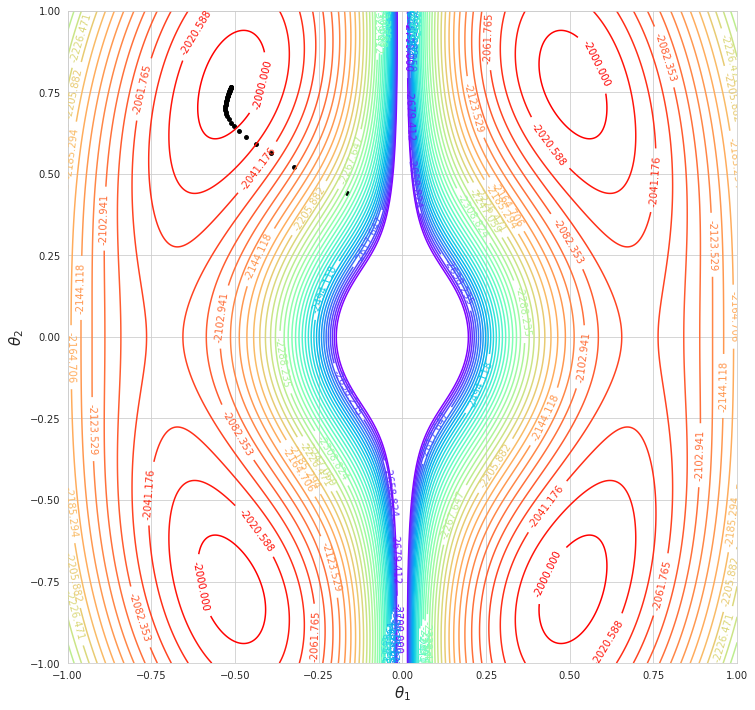

In [10]:
# code for level curves plot:
N = 500
THETA1, THETA2 = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
LOG_L = np.zeros_like(THETA1)
for i in tqdm(range(THETA1.shape[0])):
    for j in range(THETA1.shape[1]):
        LOG_L[i, j] = log_likelihood(theta1=THETA1[i, j], theta2=THETA2[i, j], p1=p1, p2=p2, X=X)
        
plt.figure(figsize=(12, 12))
CS = plt.contour(THETA1, THETA2, LOG_L, np.linspace(-2700, -2000, 35), cmap='rainbow')
plt.clabel(CS, CS.levels);
plt.scatter(theta_history[:, 0], theta_history[:, 1], color='black', s=15);
plt.xlabel(r'$\theta_{1}$', fontsize=15);
plt.ylabel(r'$\theta_{2}$', fontsize=15);